# pySCENIC protocol: downstream analyses

In [1]:
###################################
# Created on 17:08, Jan. 16th, 2021
# Author: fassial
# Filename: gen_figs.ipynb
###################################

## common dep & macro

In [2]:
# dep
import os
import json
import zlib
import base64
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
# local dep

/home/fassial/Documents/storage/Software/anaconda/envs/python36/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
## set config
# set config for sc
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(
    dpi = 150,
    fontsize = 10,
    dpi_save = 600
)
# set maximum number of jobs for sc
sc.settings.njobs = 16

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.8.3 louvain==0.6.1


In [4]:
# macro
# macro for expr
SEED_CURR = 0
# macro for filepath
DIR_ROOT = os.path.join(os.getcwd(), "..")
DIR_DATA = os.path.join(DIR_ROOT, "data")
DIR_RESOURCE = os.path.join(DIR_ROOT, "resource")
DIR_OUTPUT = os.path.join(DIR_ROOT, "output")
# macro for sce_adata file
SCE_ADATA_FNAME = "sce_adata.h5ad"
# macro for scenic files
ADJ_FNAME = "adjacencies.tsv"
REGULONS_FNAME = "regulons.csv"
AUC_FNAME = "auc-mtx.csv"
SCENIC_SRC_FNAME = "cells.scenic.src.loom"
SCENIC_RES_FNAME = "cells.scenic.res.loom"
# macro for motifs table
BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

In [5]:
# macro for metadata file
FILE_METADATA = os.path.join(DIR_DATA, "cells.pituitary.metadata.csv")

## load data

### load data from scenic.src

In [6]:
# get sce_mtx & auc_mtx
lf = lp.connect(
    filename = os.path.join(DIR_OUTPUT, ("seed-%d" % SEED_CURR), SCENIC_SRC_FNAME),
    mode = "r+",
    validate = False
)
sce_mtx = pd.DataFrame(lf[:,:], index = lf.ra.Gene, columns = lf.ca.CellID).T
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index = lf.ca.CellID)
regulons = lf.ra.Regulons
lf.close()

### load data from metadata.csv

In [7]:
metadata = pd.read_csv(FILE_METADATA,
    sep = ",",
    index_col = 0
).sort_index(ascending=True)

### add metadata to sce_adata

In [8]:
## set sce_adata
sce_adata = anndata.AnnData(X = sce_mtx)
## set sce_adata.obs
# mito and genes/counts cuts
mito_genes = sce_adata.var_names.str.startswith("Mt-")
# original obs
sce_adata.obs["n_genes"] = (sce_adata.X > 0).sum(axis=1)
sce_adata.obs["n_counts"] = sce_adata.X.sum(axis=1)
sce_adata.obs["perc_mito"] = np.sum(sce_adata[:, mito_genes].X, axis=1) / np.sum(sce_adata.X, axis=1)
# sort obs.index
sce_adata.obs = sce_adata.obs.sort_index(ascending=True)
# additional obs
sce_adata.obs["cell_type_refined"] = np.array(metadata["cell_type_refined"])
sce_adata.obs["cell_type_brief"] = np.array(metadata["cell_type_brief"])
sce_adata.obs["treat"] = np.array(metadata["treat"])
sce_adata.obs["dose"] = np.array(metadata["dose"])
sce_adata.obs["duration"] = np.array(metadata["duration"])
sce_adata.obs["stim"] = np.array(metadata["stim"])

In [9]:
sce_adata.obs

n_genes  n_counts  perc_mito   cell_type_refined  \
AACTCACC_L02      6746  116790.0        0.0     Red blood cells   
AACTCACC_L09      6238  131155.0        0.0        Somatotropes   
AACTCACC_L10      8822  264305.0        0.0        Gonadotropes   
AACTCACC_L100     6438   66371.0        0.0         Lactotropes   
AACTCACC_L101     7298   99017.0        0.0       Corticotropes   
...                ...       ...        ...                 ...   
TTCACGCA_T04      5848   94811.0        0.0        Somatotropes   
TTCACGCA_T05      7905  171248.0        0.0        Somatotropes   
TTCACGCA_T06      8364  103249.0        0.0  Pou1f1 progenitors   
TTCACGCA_T07      6268  102853.0        0.0        Somatotropes   
TTCACGCA_T08      6308  129158.0        0.0        Somatotropes   

              cell_type_brief     treat   dose duration               stim  
AACTCACC_L02             RBCs       LPS   50mg       6h        LPS 50mg 6h  
AACTCACC_L09              Som       LPS   10mg       3h        LPS 10mg 3h  
AACTCACC_L10            Gonad       LPS   10mg       3h        LPS 10mg 3h  
AACTCACC_L100             Lac       LPS  500ug       6h       LPS 500ug 6h  
AACTCACC_L101            Cort       LPS  500ug       6h       LPS 500ug 6h  
...                       ...       ...    ...      ...                ...  
TTCACGCA_T04              Som  TNFalpha  500ug       6h  TNFalpha 500ug 6h  
TTCACGCA_T05              Som  TNFalpha  500ug       6h  TNFalpha 500ug 6h  
TTCACGCA_T06           Pou1f1  TNFalpha  500ug       6h  TNFalpha 500ug 6h  
TTCACGCA_T07              Som  TNFalpha  500ug       6h  TNFalpha 500ug 6h  
TTCACGCA_T08              Som  TNFalpha  500ug       6h  TNFalpha 500ug 6h  

[5506 rows x 9 columns]

## pre-processing of expression data

normalizing by total count per cell
    finished (0:00:21): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


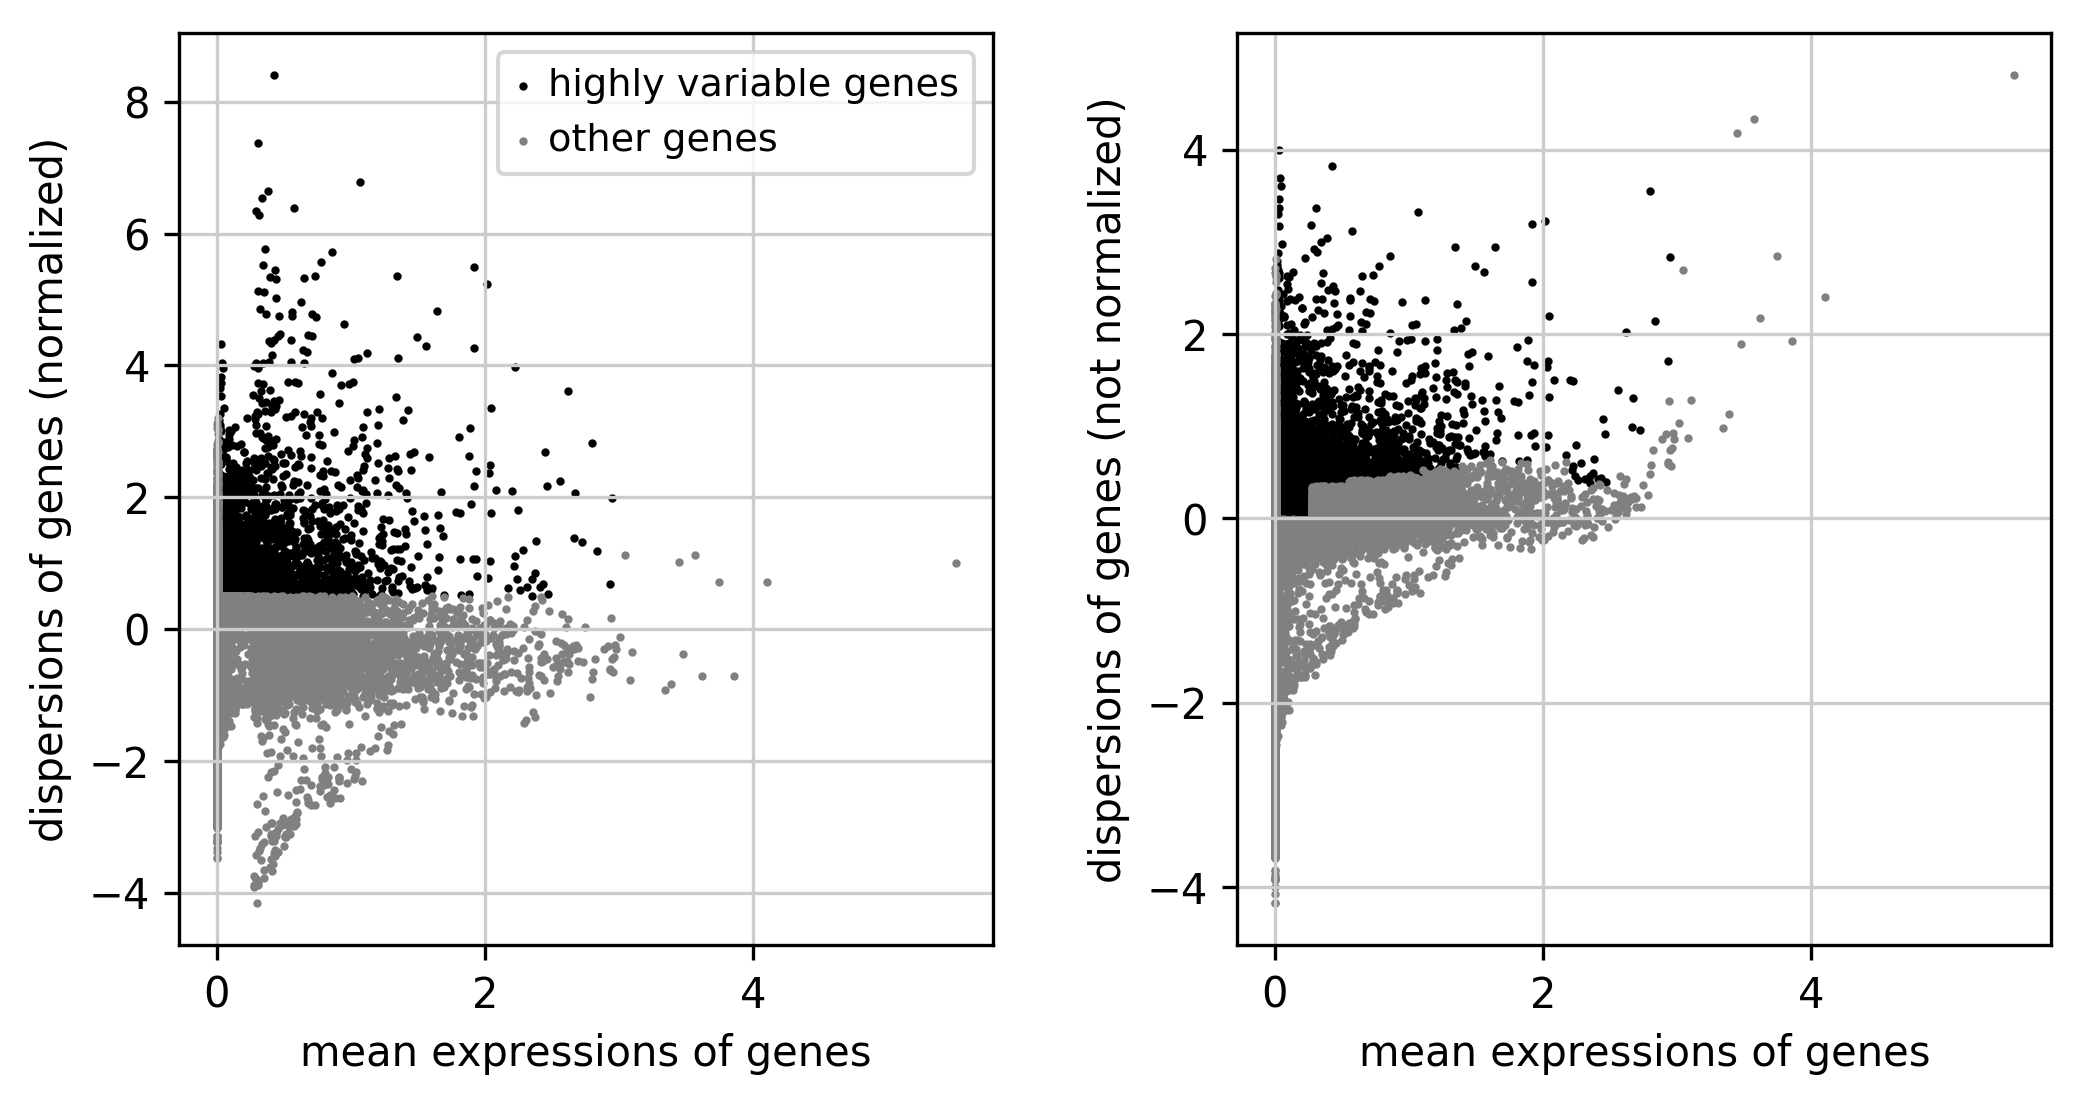

regressing out ['n_counts', 'perc_mito']


Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type_refined' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type_brief' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'treat' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'dose' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'duration' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'stim' as categorical


    finished (0:01:37)


In [10]:
# save a copy of the raw data
sce_adata.raw = sce_adata

# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_per_cell(sce_adata,
    counts_per_cell_after = 1e4
)

# log transform the data.
sc.pp.log1p(sce_adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(sce_adata,
    min_mean = 0.0125,
    max_mean = 3,
    min_disp = 0.5
)
sc.pl.highly_variable_genes(sce_adata)

# keep only highly variable genes:
sce_adata = sce_adata[:, sce_adata.var["highly_variable"]]

# AxisError: axis1: axis 1 is out of bounds for array of dimension 0
# Fixed by update scanpy's dep to the correct version
# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(sce_adata, ["n_counts", "perc_mito"]) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(sce_adata,
    max_value = 10
)

### PCA

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:04)


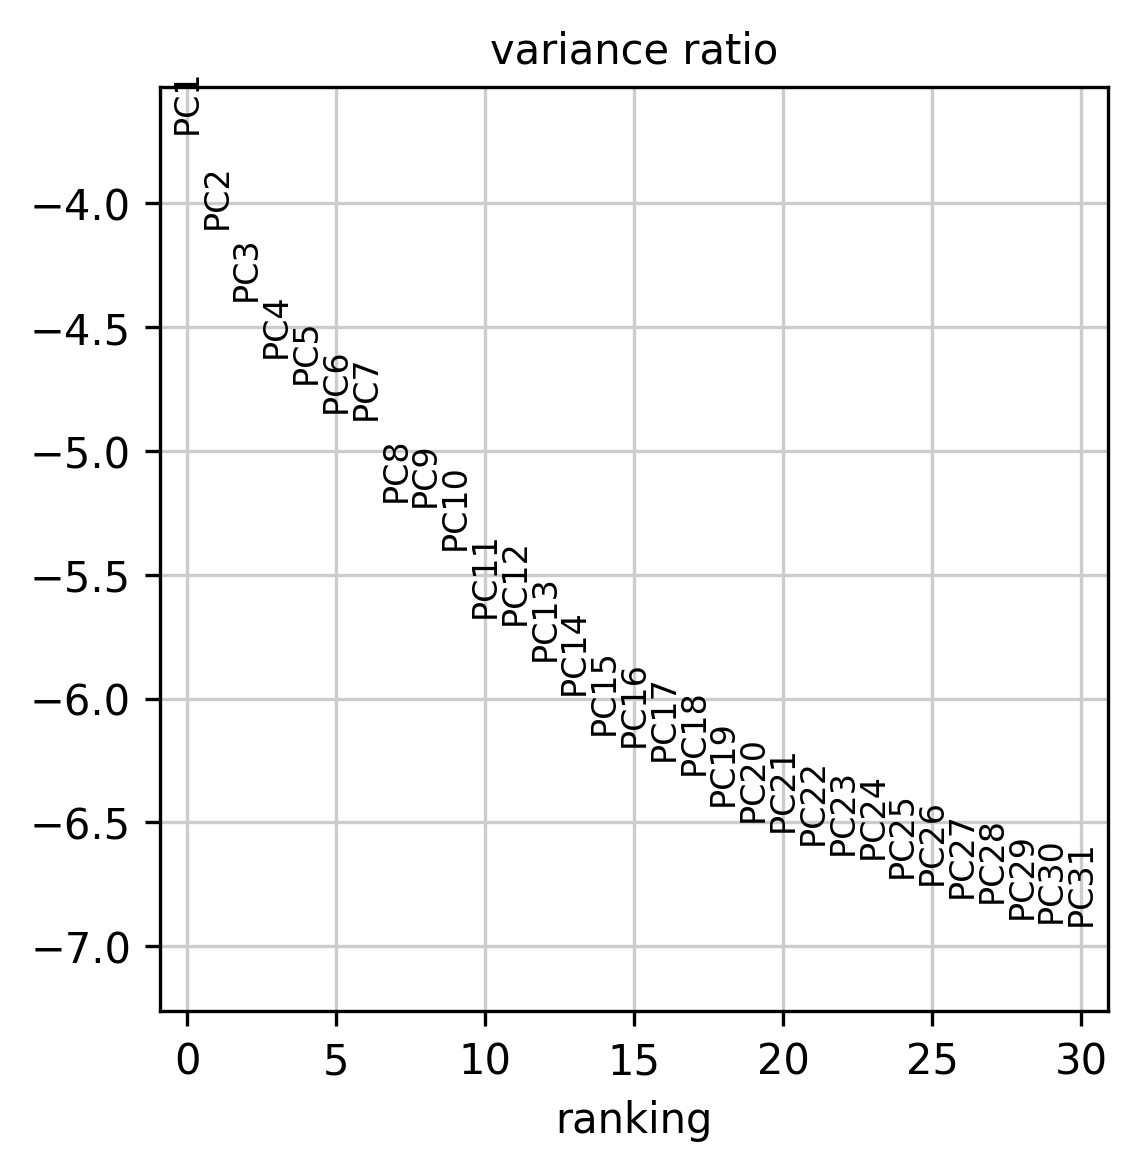

In [11]:
# principal component analysis
sc.tl.pca(sce_adata, svd_solver = "arpack")
sc.pl.pca_variance_ratio(sce_adata, log = True)

In [12]:
sce_adata

AnnData object with n_obs × n_vars = 5506 × 7920 
    obs: 'n_genes', 'n_counts', 'perc_mito', 'cell_type_refined', 'cell_type_brief', 'treat', 'dose', 'duration', 'stim'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Visualization of highly variable genes

In [13]:
# dep
from MulticoreTSNE import MulticoreTSNE as TSNE

In [14]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(sce_adata, n_neighbors = 15, n_pcs = 50)
# compute UMAP
sc.tl.umap(sce_adata)
# tSNE
tsne_inst = TSNE(n_jobs = 16)
sce_adata.obsm["X_tsne"] = tsne_inst.fit_transform(sce_adata.X)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


In [15]:
sce_adata

AnnData object with n_obs × n_vars = 5506 × 7920 
    obs: 'n_genes', 'n_counts', 'perc_mito', 'cell_type_refined', 'cell_type_brief', 'treat', 'dose', 'duration', 'stim'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

### Clustering

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


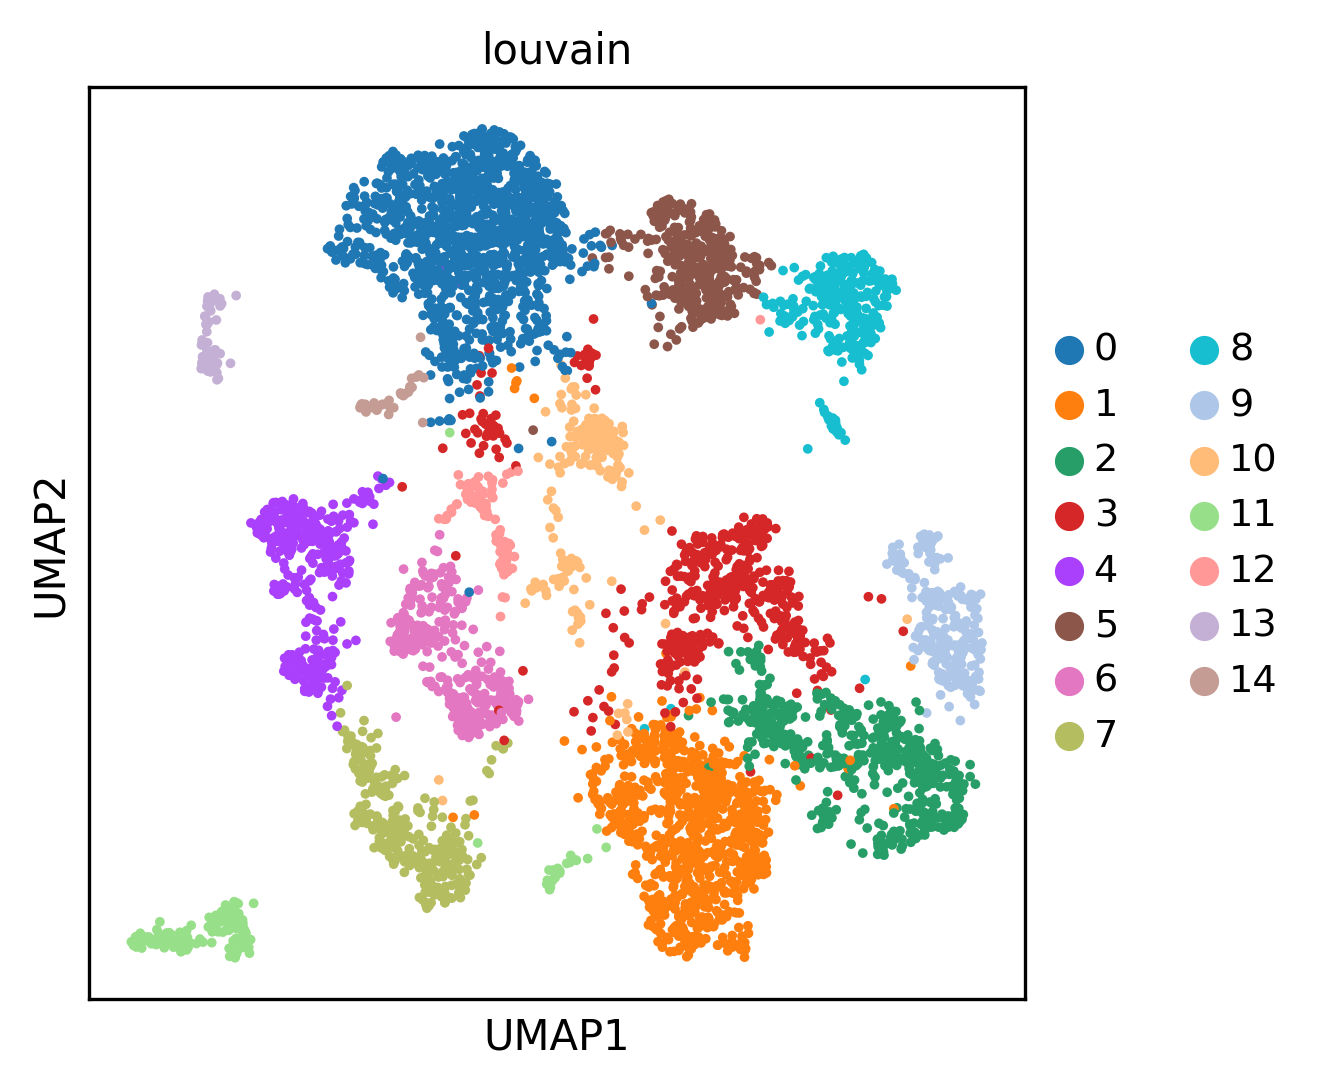

In [16]:
# cluster the neighbourhood graph
sc.tl.louvain(sce_adata,resolution=0.4)
# plot umap
sc.pl.umap(sce_adata, color=["louvain"])

ranking genes


/home/fassial/Documents/storage/Software/anaconda/envs/python36/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/fassial/Documents/storage/Software/anaconda/envs/python36/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:208: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (np.expm1(mean_group) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/fassial/Documents/storage/Software/anaconda/envs/python36/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:223: RuntimeWarning: divide by zero encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:56)


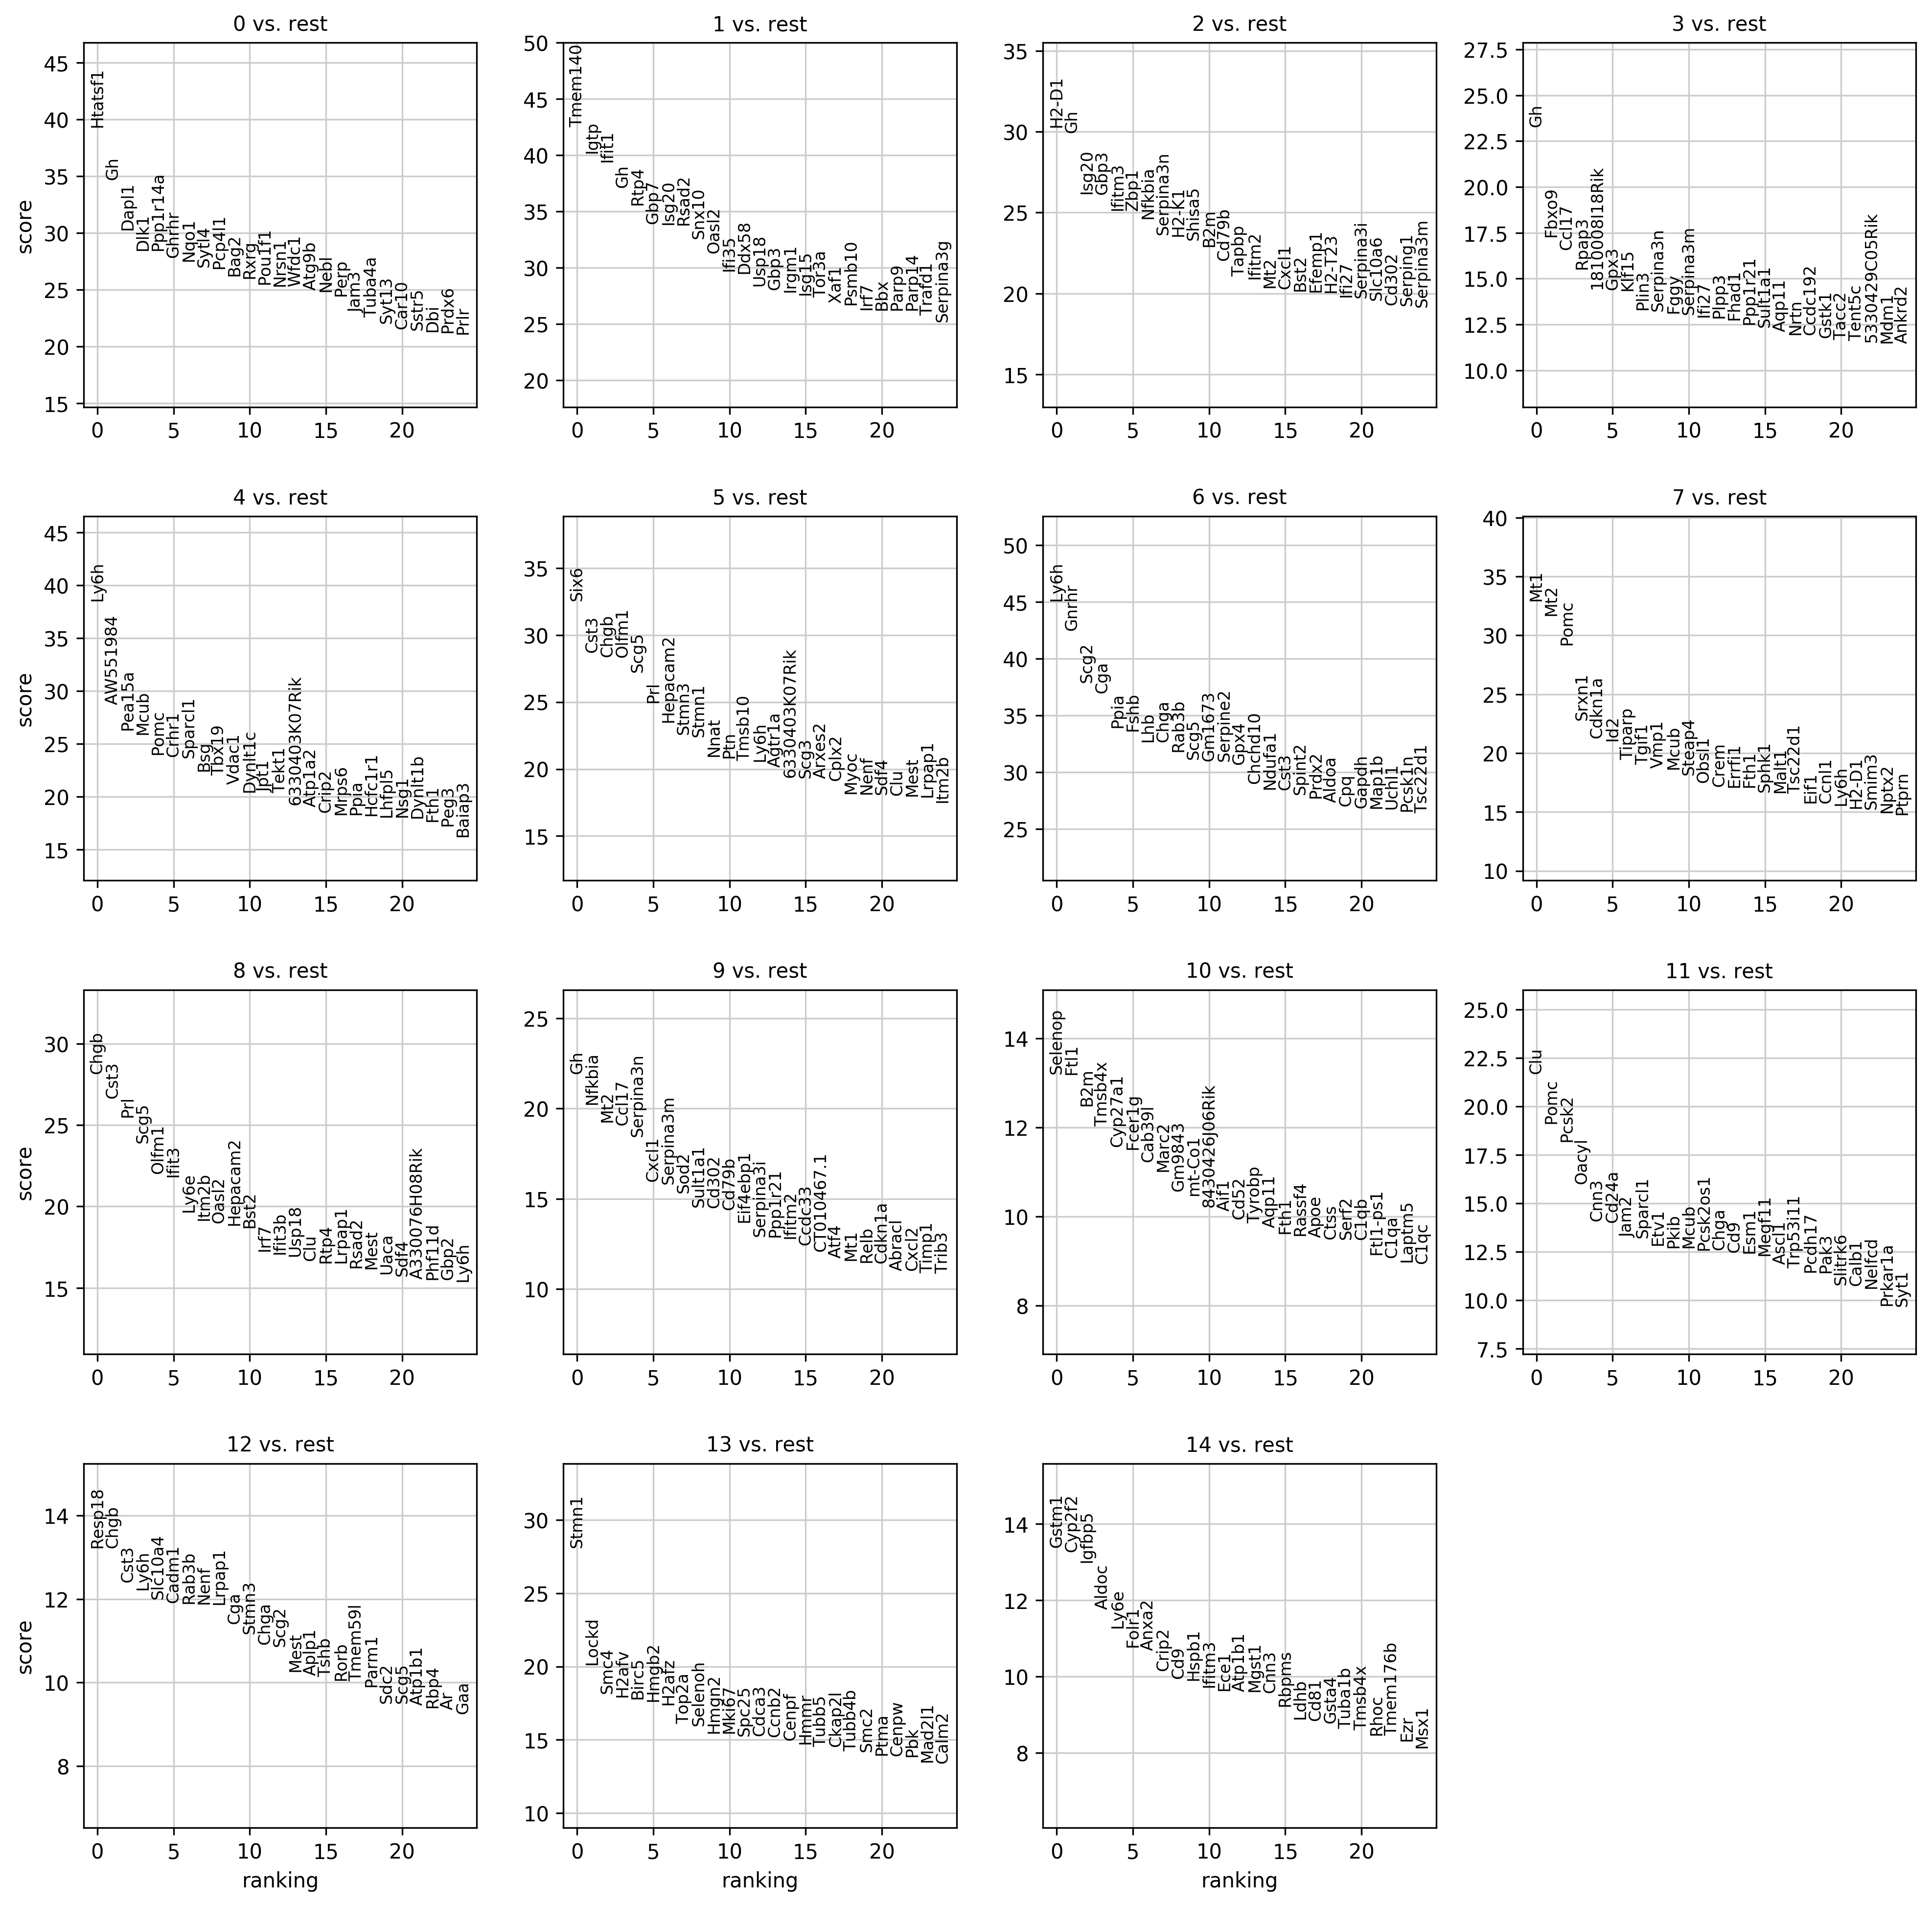

0        1          2              3         4         5      6  \
0   Htatsf1  Tmem140      H2-D1             Gh      Ly6h      Six6   Ly6h   
1        Gh     Igtp         Gh          Fbxo9  AW551984      Cst3  Gnrhr   
2     Dapl1    Ifit1      Isg20          Ccl17    Pea15a      Chgb   Scg2   
3      Dlk1       Gh       Gbp3          Rpap3      Mcub     Olfm1    Cga   
4  Ppp1r14a     Rtp4     Ifitm3  1810008I18Rik      Pomc      Scg5   Ppia   
5     Ghrhr     Gbp7       Zbp1           Gpx3     Crhr1       Prl   Fshb   
6      Nqo1    Isg20     Nfkbia          Klf15   Sparcl1  Hepacam2    Lhb   
7     Sytl4    Rsad2  Serpina3n          Plin3       Bsg     Stmn3   Chga   
8    Pcp4l1    Snx10      H2-K1      Serpina3n     Tbx19     Stmn1  Rab3b   
9      Bag2    Oasl2     Shisa5           Fggy     Vdac1      Nnat   Scg5   

        7         8          9       10       11       12       13      14  
0     Mt1      Chgb         Gh  Selenop      Clu   Resp18    Stmn1   Gstm1  
1     Mt2      Cst3     Nfkbia     Ftl1     Pomc     Chgb    Lockd  Cyp2f2  
2    Pomc       Prl        Mt2      B2m    Pcsk2     Cst3     Smc4  Igfbp5  
3   Srxn1      Scg5      Ccl17   Tmsb4x    Oacyl     Ly6h    H2afv   Aldoc  
4  Cdkn1a     Olfm1  Serpina3n  Cyp27a1     Cnn3  Slc10a4    Birc5    Ly6e  
5     Id2     Ifit3      Cxcl1   Fcer1g    Cd24a    Cadm1    Hmgb2   Folr1  
6  Tiparp      Ly6e  Serpina3m   Cab39l     Jam2    Rab3b    H2afz   Anxa2  
7   Tgif1     Itm2b       Sod2    Marc2  Sparcl1     Nenf    Top2a   Crip2  
8    Vmp1     Oasl2    Sult1a1   Gm9843     Etv1   Lrpap1  Selenoh     Cd9  
9    Mcub  Hepacam2      Cd302   mt-Co1     Pkib      Cga    Hmgn2   Hspb1

In [17]:
# find marker genes
sc.tl.rank_genes_groups(sce_adata, "louvain", method="t-test")
sc.pl.rank_genes_groups(sce_adata, n_genes=25, sharey=False)

# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(sce_adata.uns["rank_genes_groups"]["names"]).head(10)

In [18]:
sce_adata

AnnData object with n_obs × n_vars = 5506 × 7920 
    obs: 'n_genes', 'n_counts', 'perc_mito', 'cell_type_refined', 'cell_type_brief', 'treat', 'dose', 'duration', 'stim', 'louvain'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'

## visualization of SCENIC's AUC matrix

In [19]:
# dep
import umap
from MulticoreTSNE import MulticoreTSNE as TSNE

In [20]:
# UMAP
umap_inst = umap.UMAP(
    n_neighbors = 10,
    min_dist = 0.4,
    metric = "correlation"
)
dr_umap = umap_inst.fit_transform(auc_mtx)
# tSNE
tsne_inst = TSNE(n_jobs = 16)
dr_tsne = tsne_inst.fit_transform(auc_mtx)

/home/fassial/Documents/storage/Software/anaconda/envs/python36/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../home/fassial/Documents/storage/Software/anaconda/envs/python36/lib/python3.6/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/home/fassial/Documents/storage/Software/anaconda/envs/python36/lib/python3.6/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out 

In [21]:
sce_adata.obsm["X_scenic_tsne"] = dr_tsne
sce_adata.obsm["X_scenic_umap"] = dr_umap

In [22]:
sce_adata

AnnData object with n_obs × n_vars = 5506 × 7920 
    obs: 'n_genes', 'n_counts', 'perc_mito', 'cell_type_refined', 'cell_type_brief', 'treat', 'dose', 'duration', 'stim', 'louvain'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_tsne', 'X_scenic_tsne', 'X_scenic_umap'
    varm: 'PCs'

### write sce_adata to h5ad file

In [23]:
sce_adata.write(os.path.join(DIR_OUTPUT, ("seed-%d" % SEED_CURR), SCE_ADATA_FNAME))

---
# Dimensionality reduction plots

### read sce_adata from h5ad file

In [ ]:
# ValueError: invalid shape in fixed-type tuple.
# if os.path.exists(os.path.join(DIR_OUTPUT, ("seed-%d" % SEED_CURR), SCE_ADATA_FNAME)):
#     sce_adata = sc.read_h5ad(os.path.join(DIR_OUTPUT, ("seed-%d" % SEED_CURR), SCE_ADATA_FNAME))

### Show both highly variable genes and SCENIC UMAP plots with Louvain clustering and cell type classifications

In [25]:
# dep
import seaborn as sns
import matplotlib.pyplot as plt

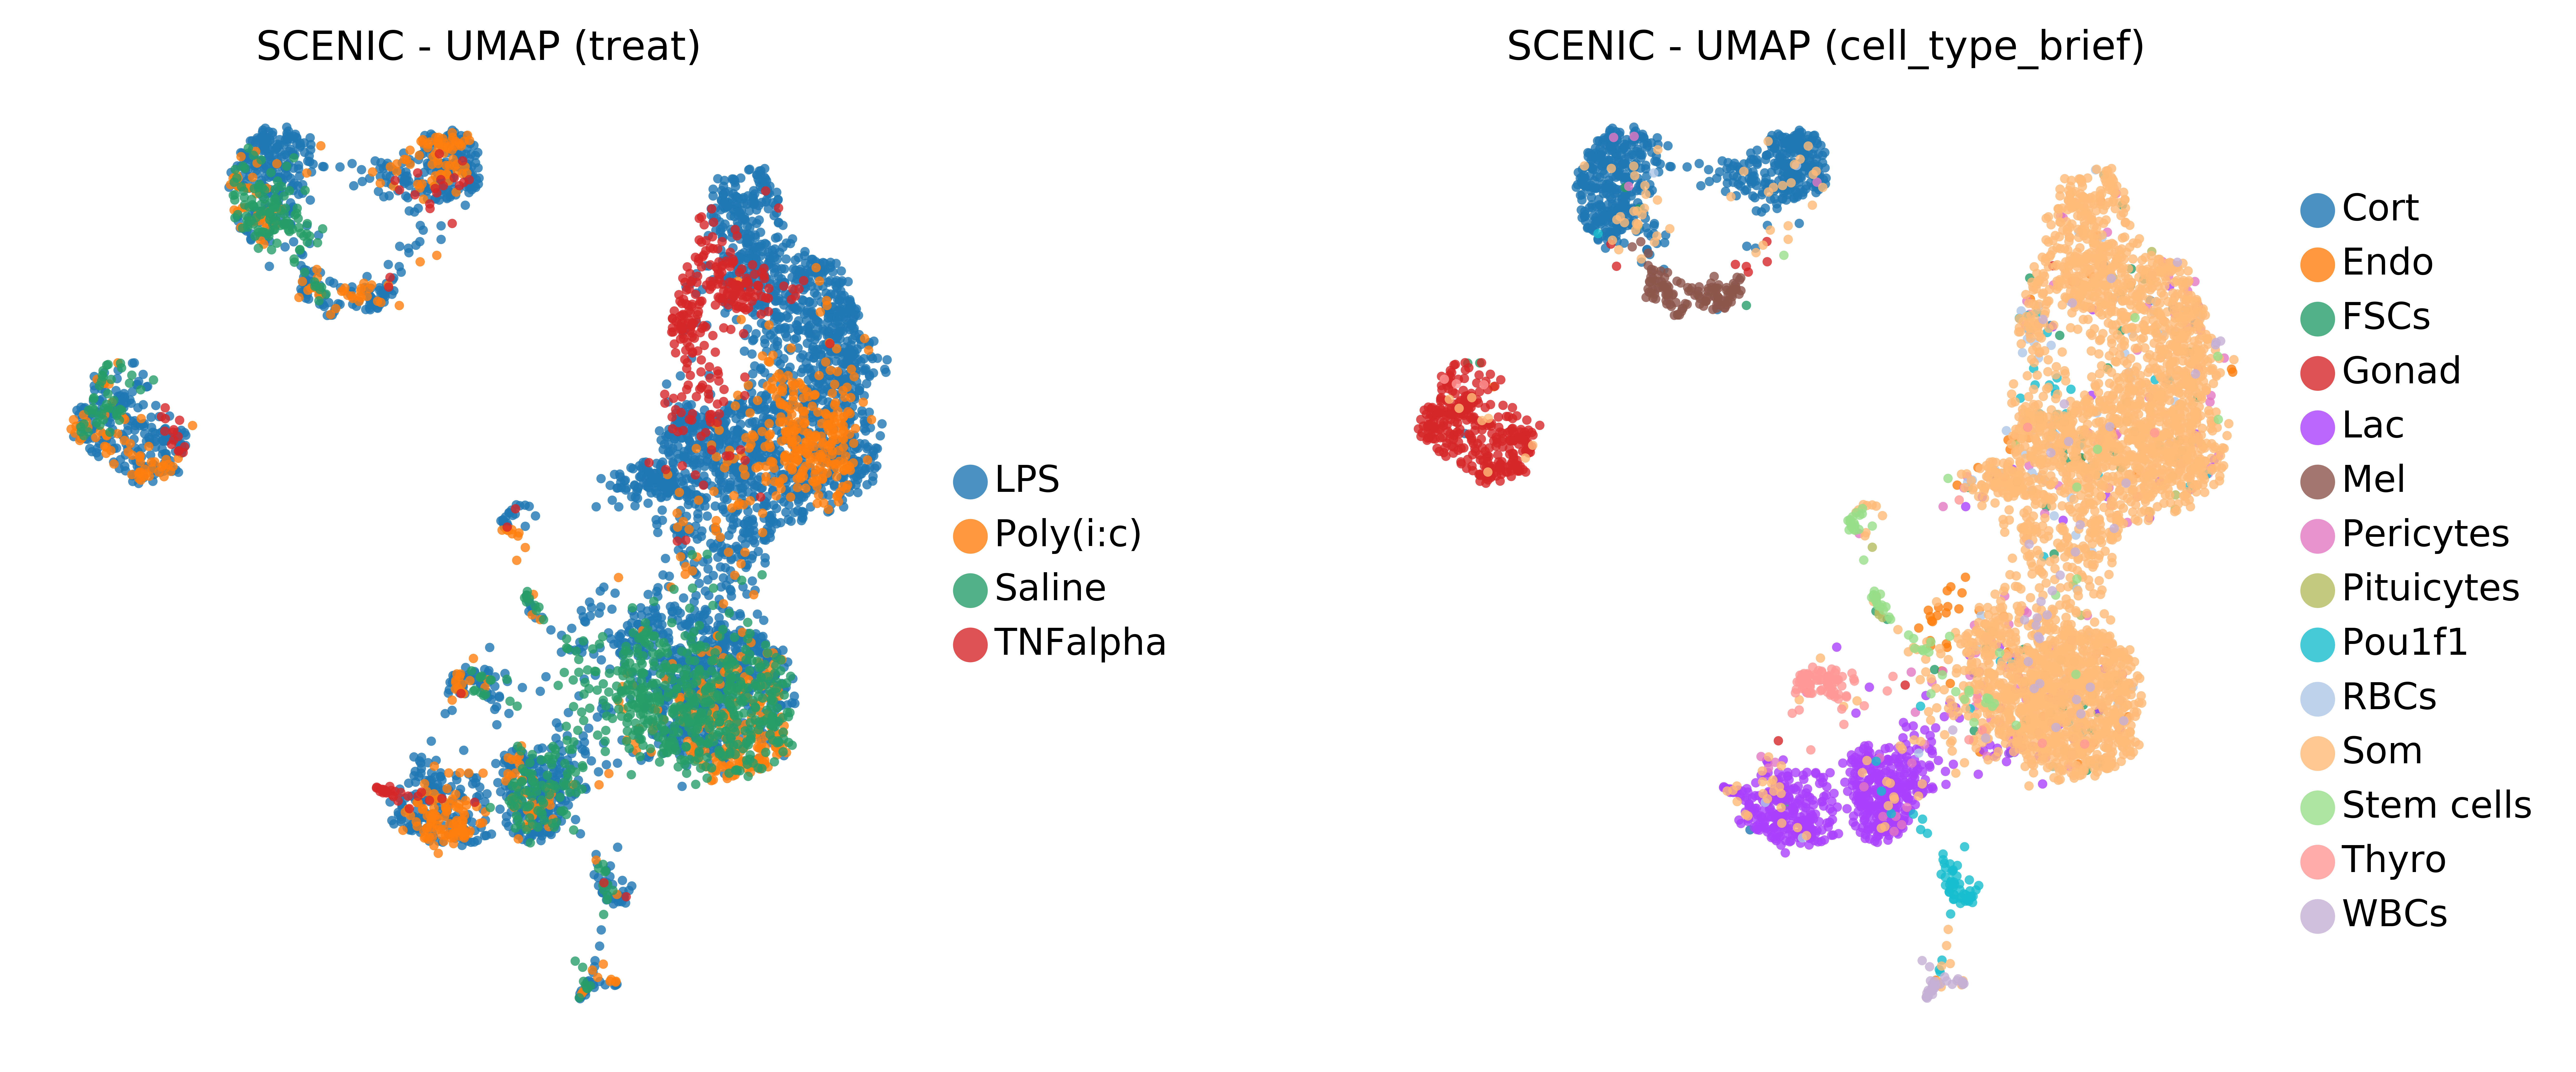

In [28]:
sc.set_figure_params(frameon=False, dpi=600, fontsize=10, dpi_save=600)

# sc.pl.scatter(sce_adata, basis="highly_variable_genes_UMAP", 
#     color=["Louvain_clusters_Scanpy", "Celltype_Garnett"],
#     title=["HVG - UMAP (Louvain clusters)", "HVG - UMAP (Cell type)"],
#     alpha=0.8,
#     save=None
# )

sc.pl.scatter(sce_adata, basis="scenic_umap", 
    color=["treat", "cell_type_brief"],
    title=["SCENIC - UMAP (treat)", "SCENIC - UMAP (cell_type_brief)"], 
    alpha=0.8,
    save=".pdf"
)

### Alternately, we can plot two dimensionality reductions side-by-side

(this uses non-Scanpy plotting functions)

In [ ]:
def colorMap( x, palette='bright' ):
    import natsort
    from collections import OrderedDict
    n=len(set(x))
    cpalette = sns.color_palette(palette,n_colors=n )
    cdict = dict( zip( list(set(x)), cpalette ))
    cmap = [ cdict[i] for i in x ]
    cdict = OrderedDict( natsort.natsorted(cdict.items()) )
    return cmap,cdict

def drplot( dr, colorlab, ax, palette='bright', title=None, **kwargs ):
    cmap,cdict = colorMap( colorlab, palette )
    for lab,col in cdict.items():
        ix = colorlab.loc[colorlab==lab].index
        ax.scatter( dr['X'][ix], dr['Y'][ix], c=[col]*len(ix), alpha=0.7, label=lab, edgecolors='none')
    if( title is not None ):
        ax.set_title(title, fontsize='x-large');
    #
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

In [ ]:
sce_adata.obsm.index = sce_adata.obs.index

In [ ]:
plt.rcParams.update({'font.size':12})

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10), dpi=150 )

dr = pd.DataFrame(sce_adata.obsm["X_umap"], index=sce_adata.obsm.index); dr.columns = ["X", "Y"]
drplot(dr, colorlab=sce_adata.obs["louvain"], ax=ax1, palette="bright", s=2, title="Highly variable genes - UMAP")

dr = pd.DataFrame(sce_adata.obsm["X_scenic_umap"], index=sce_adata.obsm.index); dr.columns = ["X", "Y"]
drplot(dr, colorlab=sce_adata.obs["louvain"], ax=ax2, palette="bright", s=2, title="SCENIC AUC - UMAP")
ax2.legend(loc="right", bbox_to_anchor=(1.15, 0.5), ncol=1, markerscale=2, fontsize="x-large", frameon=False, title="Louvain\nclusters")

plt.tight_layout()

---
# Motifs

## display motifs table

In [ ]:
# dep
import operator as op
from pyscenic.utils import load_motifs
from IPython.display import HTML, display

In [ ]:
## def utils
# def _display_motifstable func
def _display_motifstable(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return "<img src=\"{}{}.png\" style=\"max-height:124px;\"></img>".format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option("display.max_colwidth")
    pd.set_option("display.max_colwidth", 200)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option("display.max_colwidth", MAX_COL_WIDTH)

# def display_motifstable func
def display_motifstable(df_motifs: pd.DataFrame, selected_motifs: list = []):
    """
    :param df_motifs:
    :param selected_motifs:
    """
    # get df_motifs_sel
    if len(selected_motifs) == 0: df_motifs_sel = df_motifs.copy()
    else: df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values("TF") ] ,:]
    # display motifstable
    _display_motifstable(df_motifs_sel.sort_values([("Enrichment","NES")], ascending=False))

In [ ]:
# get motifs
motifs = load_motifs(os.path.join(DIR_OUTPUT, ("seed-%d" % SEED_CURR), REGULONS_FNAME))

In [ ]:
# display motifstable
display_motifstable(
    df_motifs = motifs,
    selected_motifs = ["Nr3c1"]
)

## find target TF

In [ ]:
# def _find_motifs func
def _find_motifs(motifs: pd.DataFrame, selected_gene: str = ""):
    # init cor_motifs
    cor_motifs = []
    # get target_genes
    target_genes = motifs[("Enrichment", COLUMN_NAME_TARGETS)]
    # find selected genes
    for i in range(len(target_genes)):
        for j in range(len(target_genes[i])):
            if (selected_gene == target_genes[i][j][0]):
                cor_motifs.append(target_genes.index[i])
                break
    return cor_motifs

# def find_motifs func
def find_motifs(motifs: pd.DataFrame, selected_genes: list = []):
    # init cor_motifs
    cor_motifs = {}
    # find motifs for selected gene
    for gene in selected_genes:
        cor_motifs[gene] = _find_motifs(
            motifs = motifs,
            selected_gene = gene
        )
    return cor_motifs

In [ ]:
# get motifs
motifs = load_motifs(os.path.join(DIR_OUTPUT, ("seed-%d" % SEED_CURR), REGULONS_FNAME))

In [ ]:
# find cor_motifs of selected genes
selected_genes = ["Crhr1", "Sstr5"]
cor_motifs = find_motifs(
    motifs = motifs,
    selected_genes = selected_genes
); cor_motifs

---
# Regulon specificity scores (RSS) across predicted cell types

In [ ]:
# dep
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize
import matplotlib as mpl

### Calculate RSS

In [ ]:
rss_cellType = regulon_specificity_scores(auc_mtx, cellAnnot["Celltype_Garnett"])
rss_cellType

### RSS panel plot with all cell types

In [ ]:
cats = sorted(list(set(cellAnnot["Celltype_Garnett"])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(2,5,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim(x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05)
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel("")
    ax.set_xlabel("")
    adjust_text(ax.texts,
        autoalign = "xy",
        ha = "right",
        va = "bottom",
        arrowprops = dict(arrowstyle="-",color="lightgrey"),
        precision=0.001
    )
 
fig.text(0.5, 0.0, "Regulon", ha="center", va="center", size="x-large")
fig.text(0.00, 0.5, "Regulon specificity score (RSS)", ha="center", va="center", rotation="vertical", size="x-large")
plt.tight_layout()
plt.rcParams.update({
    "figure.autolayout": True,
    "figure.titlesize": "large",
    "axes.labelsize": "medium",
    "axes.titlesize": "large",
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium"
})
# plt.savefig("PBMC10k_cellType-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

### Select the top 5 regulons from each cell type

In [ ]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

#### Generate a Z-score for each regulon to enable comparison between regulons

In [ ]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

#### Generate a heatmap

In [ ]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ["k"] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment="center", verticalalignment="center")
    return f

In [ ]:
colors = sns.color_palette("bright",n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [colorsd[x] for x in cellAnnot["Celltype_Garnett"]]

In [ ]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)
plt.savefig("PBMC10k_cellType-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

In [ ]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor="gray",
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("PBMC10k_cellType-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")

### Generate a binary regulon activity matrix:

In [ ]:
binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=25 )
binary_mtx.head()

### Show the AUC distributions for selected regulons

In [ ]:
# select regulons:
r = ["Ahr_(+)", "Atf3_(+)", "Zfp950_(+)"]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot([ auc_thresholds[ r[i] ] ]*2, ax.get_ylim(), "r:")
    ax.title.set_text(r[i])
    ax.set_xlabel("")
    
fig.text(-0.01, 0.5, "Frequency", ha="center", va="center", rotation="vertical", size="large")
fig.text(0.5, -0.01, "AUC", ha="center", va="center", rotation="horizontal", size="large")

fig.tight_layout()
# fig.savefig("PBMC10k_cellType-binaryPlot2.pdf", dpi=600, bbox_inches="tight")

---
# Regulon specificity scores (RSS) across Louvain clusters

### Calculate RSS

In [ ]:
rss_louvain = regulon_specificity_scores( auc_mtx, cellAnnot["Louvain_clusters_Scanpy"] )
rss_louvain

### RSS panel plot with all cell types

In [ ]:
cats = sorted( list(set(cellAnnot["Louvain_clusters_Scanpy"])), key=int )

fig = plt.figure(figsize=(15, 12))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_louvain.T[c]
    ax = fig.add_subplot(3,5,num)
    plot_rss(rss_louvain, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel("")
    ax.set_xlabel("")
    adjust_text(ax.texts,
        autoalign = "xy",
        ha = "right",
        va = "bottom",
        arrowprops = dict(arrowstyle="-", color="lightgrey"),
        precision = 0.001
    )
 
fig.text(0.5, 0.0, "Regulon", ha="center", va="center", size="x-large")
fig.text(0.00, 0.5, "Regulon specificity score (RSS)", ha="center", va="center", rotation="vertical", size="x-large")
plt.tight_layout()
plt.rcParams.update({
    "figure.autolayout": True,
    "figure.titlesize": "large",
    "axes.labelsize": "medium",
    "axes.titlesize": "large",
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium"
})
# plt.savefig("PBMC10k_Louvain-RSS-top5.png", dpi=150, bbox_inches = "tight")
plt.show()

### Select the top 5 regulons from each cell type

In [ ]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_louvain.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

#### Generate a heatmap

In [ ]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ["k"] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment="center", verticalalignment="center")
    return f

In [ ]:
colors = sns.color_palette("bright",n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [colorsd[x] for x in cellAnnot["Louvain_clusters_Scanpy"]]

In [ ]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

In [ ]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor="gray",
    yticklabels=False, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16)
)
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel("")
g.ax_heatmap.set_xlabel("")

---
# Further exploration of modules directly from the network inference output

In [ ]:
adjacencies = pd.read_csv(os.path.join(DIR_OUTPUT, ("seed-%d" % SEED_CURR), ADJ_FNAME),
    index_col = False,
    sep = "\t"
)

Create the modules:

In [ ]:
from pyscenic.utils import modules_from_adjacencies
modules = list(modules_from_adjacencies(adjacencies, sce_mtx))

#### pick out modules for EBF1:

In [ ]:
tf = "EBF1"
tf_mods = [ x for x in modules if x.transcription_factor==tf ]

for i,mod in enumerate( tf_mods ):
    print(f"{tf} module {str(i)}: {len(mod.genes)} genes")
print(f"{tf} regulon: {len(regulons[tf+\"_(+)\"])} genes")

write these modules, and the regulon to files:

In [ ]:
for i,mod in enumerate(tf_mods):
    with open(tf+"_module_"+str(i)+".txt", "w") as f:
        for item in mod.genes:
            f.write("%s\n" % item)
            
with open(tf+"_regulon.txt", "w") as f:
    for item in regulons[tf+"_(+)"]:
        f.write("%s\n" % item)

### These module files can be further explored in **[iRegulon](http://iregulon.aertslab.org/).**

A detailed iRegulon tutorial is available [here](http://iregulon.aertslab.org/tutorial.html)

This can produce, for example, the following image:

In [ ]:
from IPython.display import display, Image
display(Image(filename='iRegulon_screenshot_PBMC10k-EBF1.png'))